# CNN Model Figure Generation

Generate plots from data recorded during training/testing

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import pickle

import torch
from torch.utils.data import DataLoader

# Confusion Matrix Plotting

https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial

In [155]:
import os
data = {}

file_to_label = {
    "M0":0,
    "M1":1,
    "M2":2
}
for root, dirs, _ in os.walk("../../output/test"):
    for dir in dirs:
        #data[dir]
        for root_2, _, files_2 in os.walk(os.path.join(root, dir)):
            temp_files = []
            for file in files_2:
                tmp_df = pd.read_csv(os.path.join(root, dir, file), header=None)
                tmp_df = tmp_df.rename({0:"file", 1:"pred", 2:"prob_0", 3:"prob_1", 4:"prob_2"}, axis='columns')
                tmp_df["label"] = file_to_label[file] 
                temp_files.append(tmp_df)

            data[dir] = pd.concat(temp_files)
                

In [175]:
matrices = {}
from sklearn.metrics import confusion_matrix
for architecture in data.keys():
    print(architecture)
    labels = data[architecture]["label"].to_numpy()
    outputs = data[architecture]["pred"].to_numpy()
    num_classes = 3
    cm = confusion_matrix(labels, outputs)
    cm_percent = cm/cm.sum(axis=1)
    print(cm_percent)

    for i in range(num_classes):
        test_accuracy += cm[i,i]
    test_accuracy = test_accuracy / sum(cm.flatten())
    matrices[architecture] = cm_percent
    print(f"Test Accuracy: {test_accuracy:>.2%}")

efficientnet_b0
[[1.         0.         0.        ]
 [0.00833333 0.81833333 0.17333333]
 [0.10166667 0.365      0.53333333]]
Test Accuracy: 78.43%
efficientnet_b2
[[0.94166667 0.05833333 0.        ]
 [0.015      0.78666667 0.19833333]
 [0.09333333 0.26666667 0.64      ]]
Test Accuracy: 78.99%
inception_v4
[[0.98166667 0.00166667 0.01666667]
 [0.         0.89333333 0.10666667]
 [0.00833333 0.24333333 0.74833333]]
Test Accuracy: 87.49%
pnasnet
[[0.98333333 0.         0.01666667]
 [0.         0.91666667 0.08333333]
 [0.01166667 0.295      0.69333333]]
Test Accuracy: 86.49%
resnext
[[1.         0.         0.        ]
 [0.00333333 0.85833333 0.13833333]
 [0.135      0.275      0.59      ]]
Test Accuracy: 81.66%


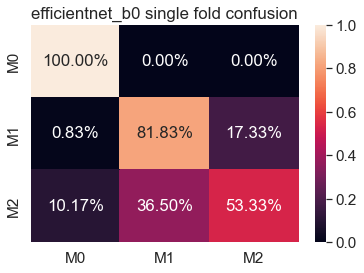

AttributeError: module 'seaborn' has no attribute 'figure'

In [186]:
import seaborn as sn
import pandas as pd


axis_labels = ["M0", "M1", "M2"]
num_classes = len(axis_labels)
for architecture in data.keys():
    plt.figure()
    matrix_df = pd.DataFrame(matrices[architecture], index=axis_labels, columns=axis_labels)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(matrix_df, annot=True, fmt='.2%') # font size
    title = architecture + ' single fold confusion'
    plt.title(title)
    plt.savefig(title + '.png')
    plt.show()
    


# Reciever Operator Characteristic Curve (ROC)


https://stackoverflow.com/questions/70278059/plotting-the-roc-curve-for-a-multiclass-problem

In [179]:
# all imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_roc_curve(y_test, y_pred, architecture):
    n_classes = len(np.unique(y_test))
    y_test = label_binarize(y_test, classes=np.arange(n_classes))

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    thresholds = dict()
    for i in range(n_classes):
      fpr[i], tpr[i], thresholds[i] = roc_curve(y_test[:, i], y_pred[:, i], drop_intermediate=False)
      roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
      mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure(figsize=(10,5))
    lw = 2
    plt.plot(fpr["micro"], tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink", linestyle=":", linewidth=4,)

    plt.plot(fpr["macro"], tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy", linestyle=":", linewidth=4,)

    colors = cycle(["aqua", "darkorange", "darkgreen", "yellow", "blue"])
    for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], color=color, lw=lw,
      label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),)

    plt.plot([0, 1], [0, 1], "k--", lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    title = "Receiver Operating Characteristic (ROC) curve for " + architecture
    plt.title(title)
    plt.legend()
    plt.savefig(title + '.png')

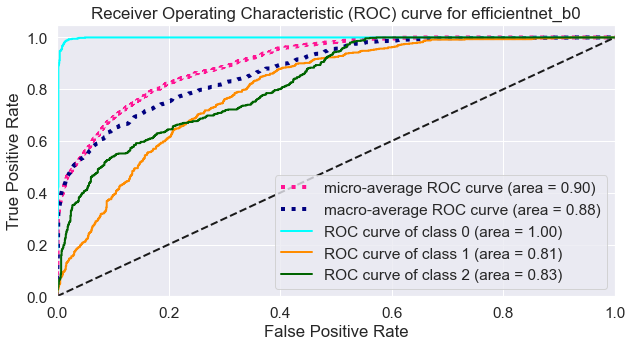

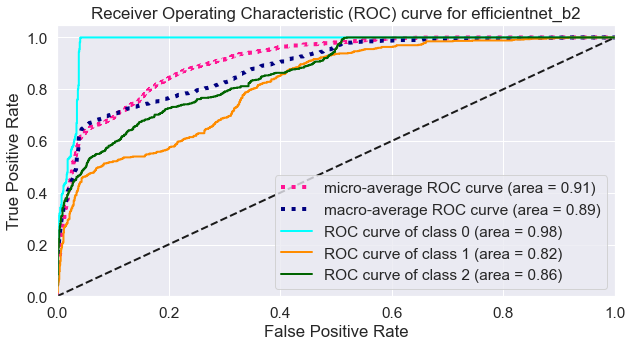

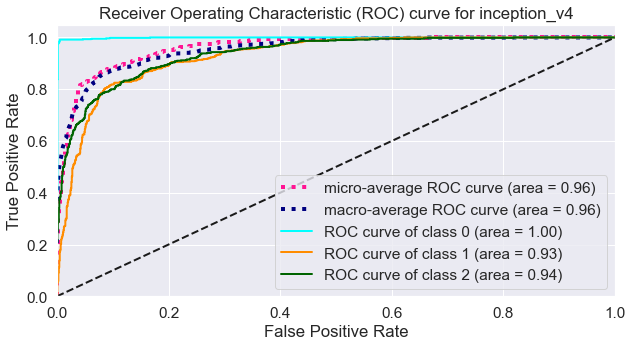

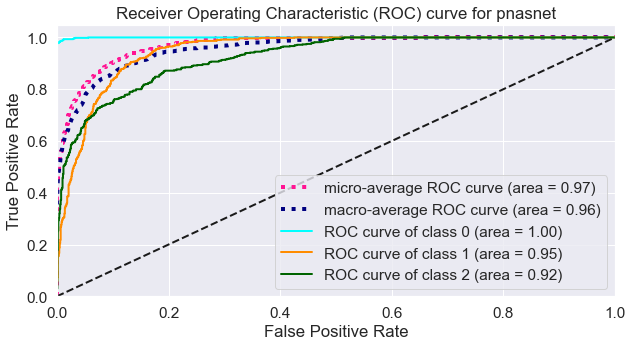

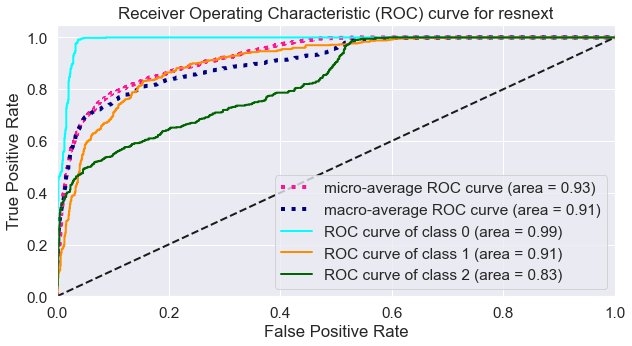

In [180]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

num_classes = 3

for architecture in data.keys():
    probs = ["prob_0", "prob_1", "prob_2"]
    labels = data[architecture]["label"].to_numpy()
    outputs = data[architecture][probs].to_numpy()
    plot_roc_curve(labels, outputs, architecture)
    

# T-SNE 

Redefining standardization operation used in training because cannot get transforms.Compose to work properly with Dataset object. TODO: Fixable 

In [ ]:
def standardize_input(image):
    image = image.detach().numpy()
    chans = range(image.shape[1])
    means = [np.mean(image[0][chan]) for chan in chans]
    stdevs = [np.std(image[0][chan]) for chan in chans]
    for chan in chans:
        image[0][chan] = (image[0][chan] - means[chan]) / stdevs[chan]
    
    output = torch.Tensor(image)
    return output

Load testing data and run inference

In [ ]:
print("Using existing trained model")
    # create model
model = create_model(
    args.model,
    pretrained=args.pretrained,
    num_classes=args.num_classes,
    in_chans=3,
    global_pool=args.gp,
    scriptable=args.torchscript)
if args.num_classes is None:
    assert hasattr(model, 'num_classes'), 'Model must have `num_classes` attr if not set on cmd line/config.'
    args.num_classes = model.num_classes

load_checkpoint(model, args.checkpoint, args.use_ema)

net = torch.load('./model_fold_0')
net.to("cpu")
net.eval()

test_data = pickle.load(open("./test_data_fold_0", "rb"))
test_sampler = equal_classes_sampler(test_data.labels)

dataloader_test = DataLoader(test_data, batch_size=1, sampler=test_sampler,
                        shuffle=False, num_workers=0)  

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

net.fc3.register_forward_hook(get_activation('fc3'))               

infer_results = pd.DataFrame(columns=['X', 'y', 'pred', 'activation'])

for batch, data in enumerate(dataloader_test):
    X, y = data[0].detach().clone(), data[1].detach().clone()
    X = standardize_input(X)
    pred = net(X[:,0:2,:,:].float())
    pred_class = torch.argmax(pred,1).item()

    X_out = data[0].detach().numpy()[0,:,:,:]
    y_out = y.detach().numpy()
    activation_out = np.array(activation['fc3'][0])
    infer_results.loc[batch] = [X_out, y_out, pred_class, activation_out]  
    

In [ ]:
from sklearn.manifold import TSNE
import seaborn as sns

TSNE = TSNE(n_components=2, perplexity=40, n_iter=10000, learning_rate=200)
activations = np.stack(infer_results["activation"].to_numpy())
tsne_results = TSNE.fit_transform(activations)
df_tsne = pd.DataFrame(tsne_results, columns=['t-sne-one', 't-sne-two'])
infer_results.drop(["activation"], axis=1)

In [ ]:
phenotype = {0: "M0",
             1: "M1",
             2: "M2"}
df_tsne['label'] = [phenotype[int(ele)] for ele in infer_results['y']]              
colors = ["#ffc814", "#0a70c4", "#db0d0d"]
customPalette = sns.set_palette(sns.color_palette(colors))
sns.scatterplot(
    x="t-sne-one", y="t-sne-two",
    hue="label",
    palette=customPalette,
    data=df_tsne,
    hue_order = ['M0', 'M1', 'M2'],
    legend="full",
    alpha=0.5
)
plt.show()
